<a href="https://colab.research.google.com/github/souravs17031999/kaggle-problems-60daysofudacity/blob/master/hot_dog_or_not_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project - HOT DOG  NOT HOT DOG Classifier
## This project aims to make a classifier that given an image of any food , capable of accurately predicting whether the image contains hot dog or not.
## This project also makes use of transfer learning and uses resnet152 pretrained model.

### Let's first download and set up kaggle so that we can easily get the dataset.
SKIP THIS PORTION 

In [0]:
!pip install kaggle

In [0]:
!mkdir .kaggle

Go to my account on kaggle and click on get my new token , and download .json file and open and copy username and key in the following piece of code.

In [0]:
import json
token = {"username":"souravs17031999","key":"c0dfc674730fdb391ccd28e80943c438"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

Set the path for downloading the files

In [10]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json


Now you can go to datasets page and then click on get API command and copy it and paste it here using '!'

In [12]:
!kaggle datasets download -d dansbecker/hot-dog-not-hot-dog

 74% 33.0M/44.6M [00:01<00:00, 16.1MB/s]
100% 44.6M/44.6M [00:01<00:00, 28.1MB/s]


In [0]:
!unzip ./{/content}/datasets/dansbecker/hot-dog-not-hot-dog/hot-dog-not-hot-dog.zip

## Let's get started by first importing all the necessary packages

In [0]:
import torch
from torch import optim, nn
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import os
import pandas as pd

## Importing drive so that we can save the checkpoint.pt file

In [0]:
model_save_name = 'classifier_hot_dog.pt'
path = F"/content/drive/My Drive/{model_save_name}"

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Importing the helper.py file to help in visualization of dataset

In [15]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

--2019-07-25 06:44:55--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2019-07-25 06:44:55 (66.1 MB/s) - ‘helper.py’ saved [2813/2813]



### Set the directory path

In [0]:
train_dir = 'train'
valid_dir = 'test'

### Apply the transforms accordingly with pre calculated means and std for the images of this dataset.

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [0]:
train_data = datasets.ImageFolder(train_dir , transform=train_transforms)
test_data = datasets.ImageFolder(valid_dir, transform=test_transforms)

In [19]:
print(len(train_data))
print(len(test_data))

498
500


### Dividing the training dataset into train set and validation set 

In [0]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [0]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### Loading the dataset with data augmentation !

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

The below code shows the structure of dataset

In [26]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")


training examples contain : 498
testing examples contain : 500


In [27]:
print(len(train_data)/64)
print(len(test_data)/64)

7.78125
7.8125


### Visualizing the images in the test set

In [0]:
images, labels = next(iter(testloader))

We have set the batch size as 64 , therefore we have here tensor of shown dimensions where 64 is batch size , 3 is color channels and 224 x 224 are height and width which we have set during data augmentation , so that each image is of same size.

In [29]:
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [0]:
class_names = train_data.classes

Function for denormalizing the pixel values 

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Function for plotting unnormalized images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


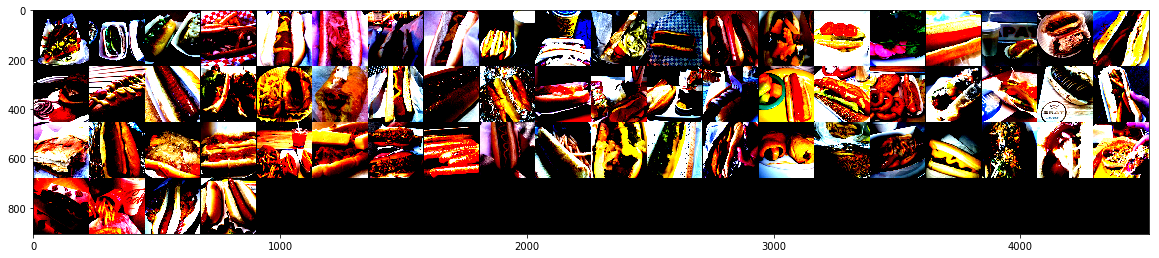

In [32]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)


Printing normalized images

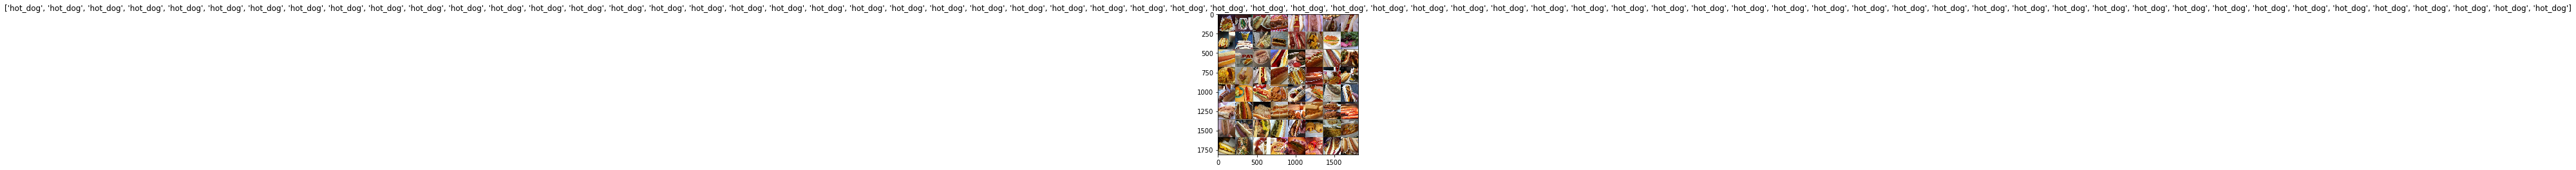

In [33]:
images, labels = next(iter(testloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])


### Checking if gpu is enabled or we are using cuda or not !

In [34]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Define the model resnet152 and the fully connected layers here with optimizer and loss functions

### Defining model , setting the param requirements , loss , optimizer ,scheduler and importing model to cuda 

In [35]:
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
        
model.fc = nn.Sequential(nn.Linear(2048, 512),nn.ReLU(),nn.Linear(512,2),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()


optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.fc.parameters()) , lr = 0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)


model.to(device);

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 101752310.11it/s]


### Let's start the normal training and validation loop.

In [0]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses = [] , []
    valid_loss_min = np.Inf 
    model.train()
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      scheduler.step()
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        print(f" epoch {epoch + 1} batch {batch} completed")
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)    

In [0]:
train_and_test(25)

Let's see model complexity graph so that we can analyse cases like overfitting.

### Let's load the checkpoint for our model so that we can again resume training or for inference

In [0]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [0]:
model = load_model(path)

### Training again starts with more layers open 

In [55]:
for name,child in model.named_children():
  if name in ['layer1','layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is unfrozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [0]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001)

In [57]:
train_and_test(50)

 epoch 1 batch 1 completed
 epoch 1 batch 2 completed
 epoch 1 batch 3 completed
 epoch 1 batch 4 completed
 epoch 1 batch 5 completed
 epoch 1 batch 6 completed
 epoch 1 batch 7 completed
Epoch: 1/50..  Training Loss: 0.080..  Valid Loss: 0.352..  Valid Accuracy: 0.880
Validation loss decreased (inf --> 0.352443).  Saving model ...
 epoch 2 batch 1 completed
 epoch 2 batch 2 completed
 epoch 2 batch 3 completed
 epoch 2 batch 4 completed
 epoch 2 batch 5 completed
 epoch 2 batch 6 completed
 epoch 2 batch 7 completed
Epoch: 2/50..  Training Loss: 0.101..  Valid Loss: 0.191..  Valid Accuracy: 0.925
Validation loss decreased (0.352443 --> 0.191295).  Saving model ...
 epoch 3 batch 1 completed
 epoch 3 batch 2 completed
 epoch 3 batch 3 completed
 epoch 3 batch 4 completed
 epoch 3 batch 5 completed
 epoch 3 batch 6 completed
 epoch 3 batch 7 completed
Epoch: 3/50..  Training Loss: 0.083..  Valid Loss: 0.176..  Valid Accuracy: 0.926
Validation loss decreased (0.191295 --> 0.176145).  Sa

### It's time for testing the model on unseen data (test set)

In [97]:
accuracy = 0
with torch.no_grad():
    model.eval()
    p_labels = []
    img_ids = []
    i = 0
    for inputs, labels in testloader:
        i += 1
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        temp_acc = torch.sum(preds == labels.data)
        accuracy += temp_acc
        p_labels.append(preds)
    for dir in os.listdir(valid_dir):
        for file in os.listdir(os.path.join(valid_dir, dir)):
            img_id = os.path.splitext(file)[0]
            img_ids.append(img_id)
    print('Accuracy =====>>', accuracy.item()/len(test_data))

Accuracy =====>> 0.928


### Let's frame our dataset using pandas in format file id , pred labels

In [0]:
pred = []
for i in p_labels:
  for j in i:
    pred.append(j.item())

In [0]:
pred

In [0]:
img_ids

We have completed this project with almost 92.8% accuracy.

In [0]:
submission = pd.DataFrame({'Id': img_ids,'Predicted': pred})


In [91]:
print(submission.head())


      Id  Predicted
0  66207          0
1   9547          0
2  47115          0
3  46401          0
4  58448          0


In [0]:
submission.to_csv('submission.csv', index=False)